## NECESSARY INSTALLS

In [2]:
!pip install tensorflow-gpu &> /dev/null
# !pip install pickle
# !pip install biosppy
# !pip install librosa

In [2]:
!nvidia-smi

Mon Jun 14 11:38:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:

# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [6]:
# import necessary modules

import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import os
import sys
import pickle
import librosa
import tqdm
# warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib as mlp
mlp.rc("xtick",labelsize=10)
mlp.rc("ytick",labelsize=10)
mlp.rc("axes",labelsize=11)
plt.rcParams["figure.figsize"] = [5,3]
plt.rcParams["figure.dpi"] = 100

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

CURR_DIR = os.getcwd()

In [7]:
tf.__version__

'2.4.1'

In [8]:

# hardware definitions
"""
https://docs.openbci.com/docs/02Cyton/CytonDataFormat#:~:text=By%20default%2C%20our%20Arduino%20sketch,of%200.02235%20microVolts%20per%20count
"""
SAMPLING_RATE = 250 #Hz
NUM_CHANNELS = 8 
ADC_RESOLUTION = 24 #bits
ADC_GAIN = 24.0
REF_VOLTAGE = 4.5 #Volts
SCALE_FACTOR = (REF_VOLTAGE/float((pow(2,23))-1)/ADC_GAIN)*1000000.0 #micro-volts

# dataset definitions
SPEAKER = ["RL","RN","SR","US"]
SESSION = ["session"+str(i) for i in range(1,9)]
MODE = ["mentally","mouthed"]
SENTENCES =["अबको समय सुनाउ","एउटा सङ्गित बजाउ","आजको मौसम बताउ","बत्तिको अवस्था बदल","पङ्खाको स्तिथी बदल"]
LABELS = np.array(SENTENCES)[[3, 2, 1, 4, 0, 3, 2, 1, 4, 0, 3, 2, 1, 4, 0]]
WORDS = ["समय","सङ्गित","मौसम","बत्ति","पङ्खा"]

SENTENCE_LABEL= np.array(SENTENCES)[[0,1,2,0,3,1,0,3,0,0,1,1,3,3,4,4,2,3,1,2,2,2,4,4,4]]
WORD_LABEL= np.array(WORDS)[[4,0,3,1,0,1,1,0,4,0,3,2,4,4,2,1,4,1,2,2,2,0,3,3,3]]




## IMPORT DATASET

In [9]:
def parser(files,NORMALIZE=True,DEPLOY=False):
    
    """
    parser function to extract utterances from .txt file and store them in a dictionary
    """
    
    # PERCENTILES FOR LENGTH NORMALIZATION
    if(NORMALIZE==True):
        percentile_95 = 1602
        percentile_97 = 1614
        percentile_99 = 1648
        percentile_100 = 1875
    else:
        percentile_95 = percentile_97 = percentile_99 = percentile_100 = -1
        
    dataset = {"data":[], "speaker":[],"session":[],"labels":[]}
    
    def get_data(file):
        
        signal = read_data(file)
        
        if(DEPLOY==True):
            dataset["data"].extend(signal)
            return
        
        if(len(signal)!=15):
            return
        
        session = file.split("/")[-2]
        speaker = file.split("/")[-3]
        
        dataset["data"].extend(signal)
        dataset["speaker"].extend([speaker]*len(signal))
        dataset["session"].extend([session]*len(signal))
        dataset["labels"].extend(LABELS)
        
    
    def read_data(file):
        f = open(file, 'r')
        contents = map(lambda x : x.strip(), f.readlines())
        #the file starts with '%' and some instruction before data and removing these data 
        frames_original = list(filter(lambda x : x and x[0] != '%', contents))[1:]
        #the data row contains channels info digital trigger and accelerometer info separated by comma
        frames_original = list(map(lambda s : list(map( lambda ss: ss.strip(), s.split(','))), frames_original))
        # (8 channels) + digital triggers
        # the digital trigger is in a[16], used to indicate the utterance
        frames = list(map(lambda a: list(map(float, a[1:9])) + [float(a[16])] , frames_original))
        frames = np.array(frames)
        indices = []
        signal = []
        for index,f in enumerate(frames[:,-1]):
            if(bool(f) ^ bool(frames[(index+1) if ((index+1)<len(frames)) else index,-1]) ):
                indices.append(index)
                if len(indices)>1 and len(indices)%2==0:
                    frame_len = indices[len(indices)-1] - indices[len(indices)-2]
                    if(frame_len<percentile_99):
                        pad = int(np.ceil((percentile_99 - frame_len)/2))
                    else:
                        pad = 0
                    left_pad = indices[len(indices)-2] - pad
                    right_pad = indices[len(indices)-1] + pad
                    a_frame = (frames[left_pad:right_pad,:-1])[:percentile_99]
                    signal.append(a_frame)
    
        # convert to microVolts and return
        return np.array(signal)*SCALE_FACTOR
        
    for file,i in zip(files,tqdm.tqdm(range(1,len(files)+1),desc="PARSING DATA")):
        get_data(file)
    
    return dataset

## PROCESS SIGNAL

In [10]:
def signal_pipeline(data,RICKER=False):

    """
    CORRECT DC DRIFT --> CORRECT DC BIAS --> SMOOTHING SIGNAL --> NORMALIZE DATA --> FILTER DATA 	
    """
    filter_data = []

    def digital_filter(data,HPF=0.5,LPF=10,H_ORDER=4,L_ORDER=4,SR=250):
        """
        HPF --> NOTCH --> LPF --> RICKER CONVOLUTION
        """

        # highpass filter
        f_signal = biosppy.signals.tools.filter_signal(data,ftype="butter",band="highpass",order=H_ORDER,sampling_rate=SR,frequency=HPF)
        # notch filter
        b,a = sig.iirnotch(50,30,SR)
        f_signal = sig.lfilter(b,a,f_signal[0])

        # lowpass filter
        f_signal = biosppy.signals.tools.filter_signal(f_signal,ftype="butter",band="lowpass",order=L_ORDER,sampling_rate=SR,frequency=LPF)

        if(RICKER==True):
            # RICKER CONVOLUTION TO REMOVE HEARTBEAT ARTIFACTS
            ricker_width = 35 * SR // 250
            ricker_sigma = 4.0 * SR / 250
            ricker = sig.ricker(ricker_width,ricker_sigma)
            # normalize ricker
            ricker = np.array(ricker, np.float32) / np.sum(np.abs(ricker))
            convolution = sig.convolve(f_signal[0],ricker,mode="same")
            return (f_signal[0]-2*convolution)

        return f_signal[0]

    def process_signal(data):
        f_data = []
        for i in range(8):
            # correction of DC drift
            c_data = data[:,i]- data[0,i]

            # correct DC bias
            c_data = c_data - np.mean(c_data)

            # normalize and filter data
            c_data = digital_filter(c_data)
            f_data.append(c_data)

        return np.array(f_data).T

    for d,i in zip(data,tqdm.tqdm(range(1,len(data)+1),desc="PROCESSING DATA: ")):
        temp_data = process_signal(d)
        filter_data.extend([temp_data])

    return np.array(filter_data)


## GET DATASET (FILTERED AND AUGMENTED)

In [13]:
DATA_PATH = "../input/silent-emg-nepali-dataset/data_dict_filtered.pickle"

In [14]:
print("Fetching filtered data from pickle file ...")
all_data_filtered = pickle.load(open(DATA_PATH,"rb"))
print("Done!")

Fetching filtered data from pickle file ...
Done!


In [15]:
print(type(all_data_filtered))
print(all_data_filtered.keys())
print([len(x[-1]) for x in all_data_filtered.items()])

<class 'dict'>
dict_keys(['data', 'speaker', 'session', 'labels'])
[6525, 6525, 6525, 6525]


In [16]:
print(np.array(all_data_filtered["data"]).shape)

(6525, 1648, 8)


## PREPARE DATASET

In [17]:
def prepare_dataset(all_data_filtered,K_FOLD=False):
    data = all_data_filtered["data"]
    labels = all_data_filtered["labels"]

    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels).astype('float64')

    print(encoded_labels[:10])
    print(all_data_filtered["labels"][:10])

    X = np.array(data)
    Y = encoded_labels
    
    if(K_FOLD==True):
        return X,Y
    
    splitter = StratifiedShuffleSplit(n_splits=1,test_size=0.1, random_state=42)

    # train test split
    train_id, test_id = next(splitter.split(X,Y))
    X_train,y_train,X_test,y_test = X[train_id],Y[train_id],X[test_id],Y[test_id]

    
    # train val split
    train_id, test_id = next(splitter.split(X_train,y_train))
    X_train,y_train,X_val,y_val = X_train[train_id],y_train[train_id],X_train[test_id],y_train[test_id]
    print("Shape of data instance: ", X_train[0].shape)
    print("Shape of Training data: ",X_train.shape)
    print("Shape of Testing data: ",X_test.shape)

    return X_train,y_train,X_val,y_val,X_test,y_test

In [18]:
X_train,y_train,X_val,y_val,X_test,y_test = prepare_dataset(all_data_filtered)
INPUT_SHAPE = X_train[0].shape 
print("Shape of Input Shape: ",INPUT_SHAPE)


[4. 1. 2. 3. 0. 4. 1. 2. 3. 0.]
['बत्तिको अवस्था बदल', 'आजको मौसम बताउ', 'एउटा सङ्गित बजाउ', 'पङ्खाको स्तिथी बदल', 'अबको समय सुनाउ', 'बत्तिको अवस्था बदल', 'आजको मौसम बताउ', 'एउटा सङ्गित बजाउ', 'पङ्खाको स्तिथी बदल', 'अबको समय सुनाउ']
Shape of data instance:  (1648, 8)
Shape of Training data:  (5284, 1648, 8)
Shape of Testing data:  (653, 1648, 8)
Shape of Input Shape:  (1648, 8)


## TRAIN MODEL

### 1D CNN (on filtered data)

In [19]:
def CNN(INPUT_SHAPE,DROPOUT=0.3,learning_rate=0.0003,activation="relu",neurons=64,K_regulizer=0.001):
    model = keras.models.Sequential()
    # 1st conv layer
    model.add(keras.layers.Conv1D(64,(3),activation="relu",input_shape=INPUT_SHAPE,
                                  kernel_regularizer=tf.keras.regularizers.l2(K_regulizer)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D((3), strides=(2), padding='same'))

    # 2nd conv layer     
    model.add(tf.keras.layers.Conv1D(32, (3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(K_regulizer)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D((3), strides=(2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv1D(32, (2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(K_regulizer)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D((2), strides=(2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    tf.keras.layers.Dropout(DROPOUT)
    
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(DROPOUT)

    # softmax output layer
    model.add(tf.keras.layers.Dense(5, activation='softmax'))
    
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
#     print(model.summary())
    return model
        


In [20]:
def run_model(model,X_train,y_train,X_val,y_val,EPOCHS=30,BATCH_SIZE=50,EARLY_STOP=True):
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=5)
    history = model.fit(X_train,y_train,epochs=30,batch_size=18,
                        validation_data=(X_val,y_val),callbacks=[earlystop_callback])
    return history,model

In [21]:
X_train,y_train,X_val,y_val,X_test,y_test = prepare_dataset(all_data_filtered)
INPUT_SHAPE = X_train[0].shape 
print("Shape of Input Shape: ",INPUT_SHAPE)
model = CNN(INPUT_SHAPE)
history,model = run_model(model,X_train,y_train,X_val,y_val)

[4. 1. 2. 3. 0. 4. 1. 2. 3. 0.]
['बत्तिको अवस्था बदल', 'आजको मौसम बताउ', 'एउटा सङ्गित बजाउ', 'पङ्खाको स्तिथी बदल', 'अबको समय सुनाउ', 'बत्तिको अवस्था बदल', 'आजको मौसम बताउ', 'एउटा सङ्गित बजाउ', 'पङ्खाको स्तिथी बदल', 'अबको समय सुनाउ']
Shape of data instance:  (1648, 8)
Shape of Training data:  (5284, 1648, 8)
Shape of Testing data:  (653, 1648, 8)
Shape of Input Shape:  (1648, 8)
Epoch 1/30
294/294 [==============================] - 6s 9ms/step - loss: 1.7200 - accuracy: 0.3849 - val_loss: 1.1374 - val_accuracy: 0.6003
Epoch 2/30
294/294 [==============================] - 2s 6ms/step - loss: 0.5887 - accuracy: 0.8377 - val_loss: 0.8310 - val_accuracy: 0.7279
Epoch 3/30
294/294 [==============================] - 2s 6ms/step - loss: 0.3184 - accuracy: 0.9377 - val_loss: 0.9080 - val_accuracy: 0.6786
Epoch 4/30
294/294 [==============================] - 2s 6ms/step - loss: 0.1971 - accuracy: 0.9785 - val_loss: 0.8050 - val_accuracy: 0.7636
Epoch 5/30
294/294 [==============================]

test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))
print(classification_report(y_pred=model.predict_classes(X_test),y_true=y_test))

In [24]:
# splitter = StratifiedShuffleSplit(n_splits=1,test_size=0.4, random_state=21)

# # testing random data from dataset
# _, test_id = next(splitter.split(X,Y))
# _,_,X_test_rand,y_test_rand = X[train_id],Y[train_id],X[test_id],Y[test_id]


In [25]:
# test_loss, test_acc = model.evaluate(X_test_rand, y_test_rand)
# print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

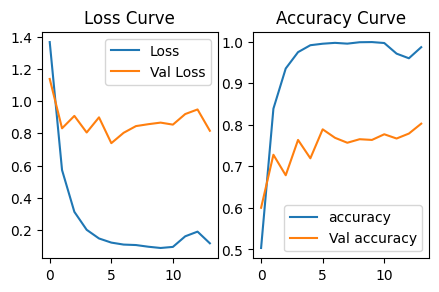

In [26]:
plt.subplot(121)
plt.title("Loss Curve")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Loss","Val Loss"])

plt.subplot(122)
plt.title("Accuracy Curve")
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy","Val accuracy"])
plt.show()

In [ ]:
plt.matshow(confusion_matrix(y_test,model.predict_classes(X_test),normalize="true"),cmap=plt.cm.Reds,interpolation="nearest")
plt.yticks(range(len(SENTENCES)), SENTENCES,fontproperties=font)
plt.xticks(range(len(SENTENCES)),SENTENCES, rotation = 45,fontproperties=font)
cm = confusion_matrix(y_test,model.predict_classes(X_test))
for i in range(len(SENTENCES)):
    for j in range(len(SENTENCES)):
        if(i==j):
            color = "w" 
        else:
            color ="black"
        plt.text(j,i, cm[i][j],horizontalalignment='center',verticalalignment='center',color=color)
plt.show()

### 1D CNN + RNN (on filtered data)

In [27]:
X_train,y_train,X_val,y_val,X_test,y_test = prepare_dataset(all_data_filtered)
INPUT_SHAPE = X_train[0].shape 

[4. 1. 2. 3. 0. 4. 1. 2. 3. 0.]
['बत्तिको अवस्था बदल', 'आजको मौसम बताउ', 'एउटा सङ्गित बजाउ', 'पङ्खाको स्तिथी बदल', 'अबको समय सुनाउ', 'बत्तिको अवस्था बदल', 'आजको मौसम बताउ', 'एउटा सङ्गित बजाउ', 'पङ्खाको स्तिथी बदल', 'अबको समय सुनाउ']
Shape of data instance:  (1648, 8)
Shape of Training data:  (5284, 1648, 8)
Shape of Testing data:  (653, 1648, 8)


In [61]:
def RNN(INPUT_SHAPE,DROPOUT=0.3,learning_rate=0.0003,activation="relu",neurons=64,K_regulizer=0.001):

    model = keras.models.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv1D(64,(3),activation="relu",input_shape=INPUT_SHAPE,
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D((3), strides=(2), padding='same'))


    model.add(tf.keras.layers.Conv1D(32, (3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D((3), strides=(2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv1D(32, (2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D((2), strides=(2), padding='same'))


    model.add(LSTM(units = 50, return_sequences = True))
    tf.keras.layers.Dropout(0.3)
    model.add(LSTM(units = 50, return_sequences = True))
    tf.keras.layers.Dropout(0.3)
    model.add(LSTM(units = 50, return_sequences = True))
    tf.keras.layers.Dropout(0.3)

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(5, activation='softmax'))
        
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
#     print(model.summary())
    return model


In [73]:
X_train,y_train,X_val,y_val,X_test,y_test = prepare_dataset(all_data_filtered)
INPUT_SHAPE = X_train[0].shape 
print("Shape of Input Shape: ",INPUT_SHAPE)
model = RNN(INPUT_SHAPE)
history,model = run_model(model,X_train,y_train,X_val,y_val)

In [59]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))
print(classification_report(y_pred=model.predict_classes(X_test),y_true=y_test))

21/21 [==============================] - 0s 3ms/step - loss: 1.0523 - accuracy: 0.7626

Test loss: 1.0523180961608887, test accuracy: 76.26339793205261
              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79       131
         1.0       0.64      0.92      0.75       130
         2.0       0.82      0.72      0.77       131
         3.0       0.87      0.68      0.76       131
         4.0       0.79      0.69      0.74       130

    accuracy                           0.76       653
   macro avg       0.78      0.76      0.76       653
weighted avg       0.78      0.76      0.76       653



/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [32]:
# model.save("1DCNN-3alyer-LSTM-3alyer-30EPOCH.h5")

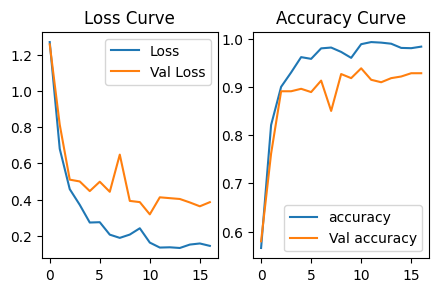

In [33]:
plt.subplot(121)
plt.title("Loss Curve")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Loss","Val Loss"])

plt.subplot(122)
plt.title("Accuracy Curve")
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy","Val accuracy"])
plt.show()

### 2D CNN (with MFCC features)

In [40]:
def extract_MFCC(all_data_filtered):
    features = []

    def MFCC(data,SR,n_mfcc=20,hop_length=80,n_fft=150):
        mfcc = librosa.feature.mfcc(data,sr=SR,n_mfcc=n_mfcc,hop_length=hop_length,n_fft=n_fft)
        return mfcc.T

    for d,i in zip(all_data_filtered["data"],tqdm.tqdm(range(1,len(all_data_filtered["data"])+1),desc="Extracting MFCC")):
        mfccs = []
        for i in range(8):
            mfcc = MFCC(np.asfortranarray(d[:,i]),SR=250)
            mfccs.append(mfcc)
        features.append(mfccs)

    shape = np.array(features).shape
    print(shape)
    return features
    # pickle.dump(features,open(os.path.join(PICKLE_DIR,"MFCC.pickle"),"wb"))


In [35]:
features= extract_MFCC(all_data_filtered)
features = np.array(features)
features = features.reshape(-1,features.shape[-2],features.shape[-1],8)
feature_dict = {"data":features,"labels":all_data_filtered["labels"]}


Extracting MFCC:   0%|          | 0/6525 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
Extracting MFCC: 100%|█████████▉| 6524/6525 [01:59<00:00, 54.69it/s]


(6525, 8, 28, 22)


In [36]:
X_train,y_train,X_val,y_val,X_test,y_test = prepare_dataset(feature_dict)
INPUT_SHAPE = X_train[0].shape 

[4. 1. 2. 3. 0. 4. 1. 2. 3. 0.]
['बत्तिको अवस्था बदल', 'आजको मौसम बताउ', 'एउटा सङ्गित बजाउ', 'पङ्खाको स्तिथी बदल', 'अबको समय सुनाउ', 'बत्तिको अवस्था बदल', 'आजको मौसम बताउ', 'एउटा सङ्गित बजाउ', 'पङ्खाको स्तिथी बदल', 'अबको समय सुनाउ']
Shape of data instance:  (28, 22, 8)
Shape of Training data:  (5284, 28, 22, 8)
Shape of Testing data:  (653, 28, 22, 8)


In [37]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",input_shape=INPUT_SHAPE,kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

# # 3rd conv layer
model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

# flatten output and feed into dense layer
model.add(tf.keras.layers.Flatten())
tf.keras.layers.Dropout(0.3)
model.add(tf.keras.layers.Dense(64, activation='relu'))
tf.keras.layers.Dropout(0.3)

# softmax output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [38]:
model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=5)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 20, 64)        4672      
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 20, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 10, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 8, 32)         18464     
_________________________________________________________________
batch_normalization_7 (Batch (None, 11, 8, 32)         128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 4, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 3, 32)         

In [39]:
history = model.fit(X_train,y_train,epochs=30,batch_size=40,validation_data=(X_val,y_val),callbacks=[earlystop_callback])

Epoch 1/30
133/133 [==============================] - 1s 6ms/step - loss: 1.8745 - accuracy: 0.2019 - val_loss: 1.7109 - val_accuracy: 0.2126
Epoch 2/30
133/133 [==============================] - 1s 4ms/step - loss: 1.7094 - accuracy: 0.2245 - val_loss: 1.7556 - val_accuracy: 0.2041
Epoch 3/30
133/133 [==============================] - 1s 4ms/step - loss: 1.6853 - accuracy: 0.2528 - val_loss: 1.7044 - val_accuracy: 0.2160
Epoch 4/30
133/133 [==============================] - 1s 4ms/step - loss: 1.6706 - accuracy: 0.2598 - val_loss: 1.9016 - val_accuracy: 0.1990
Epoch 5/30
133/133 [==============================] - 1s 4ms/step - loss: 1.6685 - accuracy: 0.2757 - val_loss: 1.8495 - val_accuracy: 0.1990
Epoch 6/30
133/133 [==============================] - 1s 4ms/step - loss: 1.6326 - accuracy: 0.2978 - val_loss: 2.4143 - val_accuracy: 0.1990
Epoch 7/30
133/133 [==============================] - 1s 4ms/step - loss: 1.6666 - accuracy: 0.2631 - val_loss: 2.4249 - val_accuracy: 0.2007
Epoch 

In [41]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))
print(classification_report(y_pred=model.predict_classes(X_test),y_true=y_test))

21/21 [==============================] - 0s 3ms/step - loss: 1.1909 - accuracy: 0.5697

Test loss: 1.1908795833587646, test accuracy: 56.96784257888794
              precision    recall  f1-score   support

         0.0       0.49      0.65      0.56       131
         1.0       0.79      0.28      0.42       130
         2.0       0.51      0.82      0.63       131
         3.0       0.69      0.65      0.67       131
         4.0       0.58      0.44      0.50       130

    accuracy                           0.57       653
   macro avg       0.61      0.57      0.56       653
weighted avg       0.61      0.57      0.56       653



/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


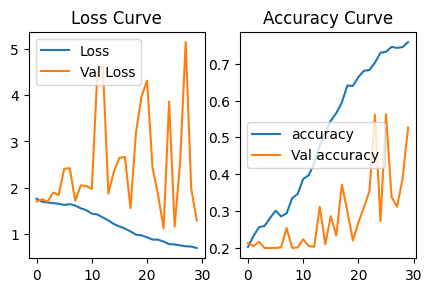

In [42]:
plt.subplot(121)
plt.title("Loss Curve")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Loss","Val Loss"])

plt.subplot(122)
plt.title("Accuracy Curve")
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy","Val accuracy"])
plt.show()

## 10 FOLD CROSS-VALIDATION

In [66]:
def K_fold_CV(all_data_filtered,which_model,K=10):
    kfold = StratifiedKFold(n_splits=K)
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=8)
    X_new,Y_new = prepare_dataset(all_data_filtered,K_FOLD=True)
    INPUT_SHAPE = X_new[0].shape 
    print("Shape of Input Shape: ",INPUT_SHAPE)
    acc = []
    count = 1
    for train_id,test_id in kfold.split(X_new,Y_new):
        print("Running Fold "+str(count)+" ... ")
        count+=1
#         model = CNN(INPUT_SHAPE)
#         model = RNN(INPUT_SHAPE)
        model = which_model(INPUT_SHAPE)
        history = model.fit(X_new[train_id],Y_new[train_id],epochs=30,batch_size=40,callbacks=[earlystop_callback],verbose=0)
        accuracy = model.evaluate(X_new[test_id],Y_new[test_id])[-1]
        acc.append(accuracy)
    return np.array(acc)

In [46]:
acc = K_fold_CV(all_data_filtered,CNN)

[4. 1. 2. 3. 0. 4. 1. 2. 3. 0.]
['बत्तिको अवस्था बदल', 'आजको मौसम बताउ', 'एउटा सङ्गित बजाउ', 'पङ्खाको स्तिथी बदल', 'अबको समय सुनाउ', 'बत्तिको अवस्था बदल', 'आजको मौसम बताउ', 'एउटा सङ्गित बजाउ', 'पङ्खाको स्तिथी बदल', 'अबको समय सुनाउ']
Shape of Input Shape:  (1648, 8)
Running Fold 1 ... 
21/21 [==============================] - 0s 4ms/step - loss: 1.9430 - accuracy: 0.5544
Running Fold 2 ... 
21/21 [==============================] - 0s 3ms/step - loss: 1.3625 - accuracy: 0.6263
Running Fold 3 ... 
21/21 [==============================] - 0s 3ms/step - loss: 2.5072 - accuracy: 0.4946
Running Fold 4 ... 
21/21 [==============================] - 0s 3ms/step - loss: 1.5169 - accuracy: 0.6110
Running Fold 5 ... 
21/21 [==============================] - 0s 3ms/step - loss: 1.5006 - accuracy: 0.6172
Running Fold 6 ... 
21/21 [==============================] - 0s 3ms/step - loss: 2.2167 - accuracy: 0.5031
Running Fold 7 ... 
21/21 [==============================] - 0s 3ms/step - loss: 1.9687 - ac

In [47]:
print(acc)

[0.55436444 0.62633997 0.49464011 0.61102605 0.61715162 0.50306749
 0.64110428 0.62116563 0.5766871  0.51073617]


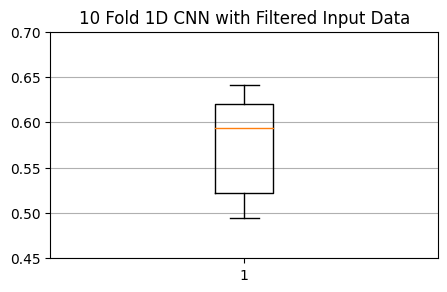

In [55]:
plt.title("10 Fold 1D CNN with Filtered Input Data")
plt.boxplot(acc)
plt.ylim(0.45,0.7)
plt.grid(axis="y")
plt.show()

In [63]:
acc = K_fold_CV(all_data_filtered,RNN)

[4. 1. 2. 3. 0. 4. 1. 2. 3. 0.]
['बत्तिको अवस्था बदल', 'आजको मौसम बताउ', 'एउटा सङ्गित बजाउ', 'पङ्खाको स्तिथी बदल', 'अबको समय सुनाउ', 'बत्तिको अवस्था बदल', 'आजको मौसम बताउ', 'एउटा सङ्गित बजाउ', 'पङ्खाको स्तिथी बदल', 'अबको समय सुनाउ']
Shape of Input Shape:  (1648, 8)
Running Fold 1 ... 
21/21 [==============================] - 1s 13ms/step - loss: 0.9186 - accuracy: 0.8147
Running Fold 2 ... 
21/21 [==============================] - 1s 13ms/step - loss: 0.3415 - accuracy: 0.9204
Running Fold 3 ... 
21/21 [==============================] - 2s 12ms/step - loss: 0.6543 - accuracy: 0.8285
Running Fold 4 ... 
21/21 [==============================] - 1s 15ms/step - loss: 0.4891 - accuracy: 0.8989
Running Fold 5 ... 
21/21 [==============================] - 1s 12ms/step - loss: 0.8426 - accuracy: 0.8178
Running Fold 6 ... 
21/21 [==============================] - 1s 12ms/step - loss: 0.8563 - accuracy: 0.7899
Running Fold 7 ... 
21/21 [==============================] - 1s 13ms/step - loss: 0.54

In [69]:
acc= [0.81470138, 0.92036754, 0.82848394, 0.89892805, 0.81776416, 0.7898773,
 0.87730062, 0.87730062, 0.87730062, 0.86042947]
print(acc)

[0.81470138, 0.92036754, 0.82848394, 0.89892805, 0.81776416, 0.7898773, 0.87730062, 0.87730062, 0.87730062, 0.86042947]


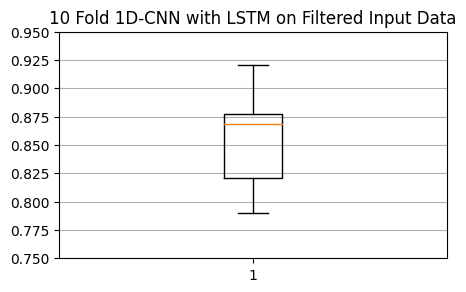

In [72]:
plt.title("10 Fold 1D-CNN with LSTM on Filtered Input Data")
plt.boxplot(acc)
plt.ylim(0.75,0.95)
plt.grid(axis="y")
plt.show()